# Sktime 

---

### &emsp; O ''sklearn'' voltado a regressão, classificação e forecasting de séries temporais.

&emsp; **Sktime** é um pacote voltado a machine learning com **séries temporais**, extendendo as funcionalidades do scikit-learn para este tipo de análise.

De acordo com seus criadores: <br>

    *“o sktime permite aprendizado de máquina compreensível e compostável com séries temporais. Ele fornece algoritmos compatíveis com o scikit-learn e ferramentas de composição de modelos, suportadas por uma taxonomia clara de tarefas de aprendizado, com documentação instrutiva e uma comunidade amigável. ”*

# Estrutura dos dados

---

Ao contrário da estrutura convencional utilizada nas análises com scikit-learn, o **sktime** usa uma estrutura de dados aninhada para séries temporais nos dataframes do pandas.

Normalmente utilizamos a estrutura em que cada coluna é uma váriavel (Xn) e cada linha uma observação. 
<br>
<img src="https://miro.medium.com/max/875/1*7lS03x5KDcVPVeK-SXvygA.png">
<br>
Utilizando **sktime** uma única coluna representará o **X** e poderá conter uma série temporal inteira.
<br>
<img src="https://miro.medium.com/max/319/1*eSmPGT0uNqtW5-86pjqQuw.png">
<br>
Este método permite o uso instantaneo de métodos padrões do pandas e scikit-learn na resolução de séries temporais.

### O que o sktime pode fazer?

De acordo com a página do Github, o sktime atualmente fornece:

- Algoritmos de última geração para classificação, regressão e previsão de séries temporais (portados do kit de ferramentas tsml baseado em Java);
- Transformadores para séries temporais: transformações de série única (por exemplo, detrending ou dessazonalização), transformações de série como recurso (por exemplo, extratores de recurso) e ferramentas para compor diferentes transformadores;
- Pipelines para transformadores e modelos;
- Tuning do modelo;
- Modelos ensemble, como uma floresta aleatória totalmente personalizável para classificação e regressão de séries temporais e modelos ensemble para problemas multivariados.

### Aplicando sktime

Para seus modelos/estimadores a utilização é similar ao sklearn, podendo ser aplicados os métodos de classe **fit**, **predict** e **transform**.

O **estimador** do sktime extende os regressores e classificadores comuns do scikit-learn para sua contraparte em séries temporais. Além destes, temos alguns estimadores novos especificos para tarefas envolvendo séries temporais.

Nas classes de transformação temos os métodos **fit** e **predict** e as seguintes opções disponíveis:

- Transformadores de dados tabulares como **PCA** operando sobre cada instancia 
- Transformadores séries-para-primitivos, convertendo séries temporaislinha-a-linha para um número primitivo (ex: feature transaction).
- Transformadores séries-para-séries convertendo diferentes tipos de séries (Ex: Transformada Fourier)
- Transformadores de retirada de tendência (Ex: Retirar tendência sazonal)

### Exemplo em código:

O exemplo a seguir utilizará um dos datasets de exemplo da própria biblioteca. O dataset neste exemplo mostra o número de passageiros de uma companhia aérea entre os anos de 1949 e 1960.

In [19]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting.forecasting import plot_ys

Para manipular este dataset utilizaremos duas funções próprias do pacote:

- `temporal_train_test_split`, muito similar ao train_test_split convencional
- `plot_ys` que permite plotar os valores de saída de treino e teste

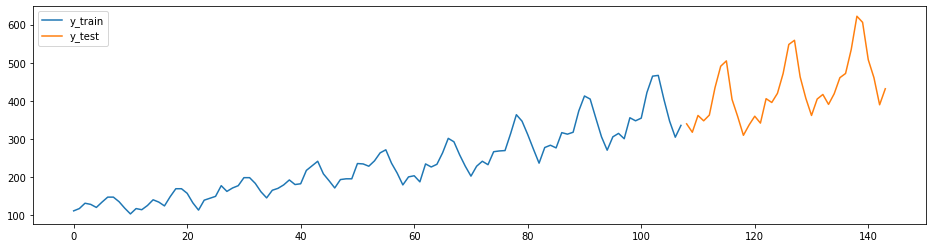

In [8]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y)
plot_ys(y_train, y_test, labels=["y_train", "y_test"]);

Criaremos nosso horizonte de previsão para poder prever os valores dos próximos 36 meses:

In [9]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

Normalmente utilizamos um modelo de baseline como primeiro passo na construção de modelos preditivos, visando comparar os modelos subsequentes com o modelo simples feito previamente. Neste caso usaremos o método `NaiveForescaster`, com diferentes estratégias.  

Utilizando o parâmetro `strategy` com o valor `last`, teremos o **último valor** da série temporal sendo replicado para todas as previsões. Também podemos utilizar o valor `seasonal_last`, repetindo o último valor da nossa janela **sazonal** para todas as previsões. Para este exemplo utilizaremos a sazonalidade de 12 meses, portanto nosso `sp`será 12.

Para métrica de avaliação utilizaremos o `smape_loss`, também já incluido na biblioteca. 
O erro percentual absoluto (SMAPE ou sMAPE) é uma medida de precisão baseado em percentagem (ou relativa) erros, e é utilizado frequentemente como métrica para previsão de séries temporais. 


SMAPE para estratégia last:  0.2319577038795143
SMAPE para estratégia seasonal_last:  0.145427686270316



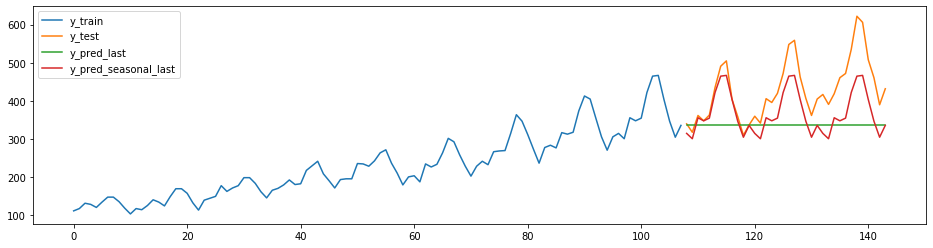

In [10]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import smape_loss

# Naive Forecaster com estratégia ''last''
naive_forecaster_last = NaiveForecaster(strategy="last")
naive_forecaster_last.fit(y_train)
y_last = naive_forecaster_last.predict(fh)

# Naive Forecaster com estratégia ''seasonal_last'' e sp = 12
naive_forecaster_seasonal_last = NaiveForecaster(strategy="seasonal_last", sp = 12)
naive_forecaster_seasonal_last.fit(y_train)
y_seasonal_last = naive_forecaster_seasonal_last.predict(fh)

plot_ys(y_train, y_test, y_last,y_seasonal_last, labels=["y_train", "y_test", "y_pred_last","y_pred_seasonal_last"]);
print('')
print('SMAPE para estratégia ''last'': ', smape_loss(y_last, y_test))
print('SMAPE para estratégia ''seasonal_last'': ', smape_loss(y_seasonal_last, y_test))
print('')

Agora podemos começar a utilizar previsões mais avançadas, no exemplo a seguir utilizaremos um previsor oriundo do pacote **sklearn**, instanciamos o `RandomForestRegressor` e mostraremos como é possível utilizá-lo dentro da biblioteca **sktime**

Utilizando o método `ReducedRegressionForecaster` e passando o estimador criado pelo `RandomForestRegressor` a biblioteca fará a transformação do dataset em janelas de acordo com o valor passado em `window_length`. 


SMAPE usando Floresta Aleatória:  0.1278587373701908



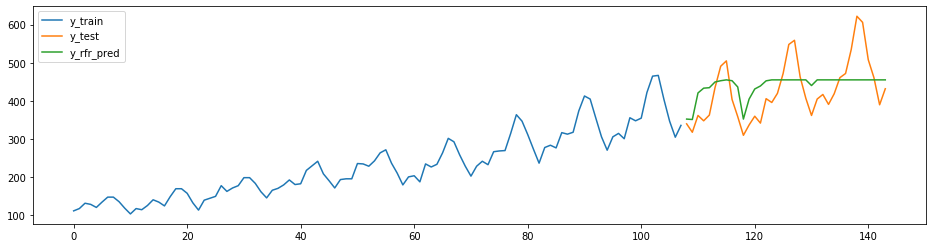

In [11]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr_forecaster = ReducedRegressionForecaster(rfr, window_length=12)
rfr_forecaster.fit(y_train)
y_rfr_pred = rfr_forecaster.predict(fh)

plot_ys(y_train, y_test, y_rfr_pred, labels=['y_train', 'y_test', 'y_rfr_pred'])
print('')
print('SMAPE usando Floresta Aleatória: ', smape_loss(y_rfr_pred, y_test))
print('')

O principio do forecasting através do ReducedRegressionForecaster é utilizar qualquer regressor proviniente do **sklearn** e aplicar reduzindo os dados para regressão tabular.

A seguir outros exemplos desta aplicação:


SMAPE usando Regressão Linear:  0.10265807074276838
SMAPE usando Árvore de Decisão:  0.11670285906512991



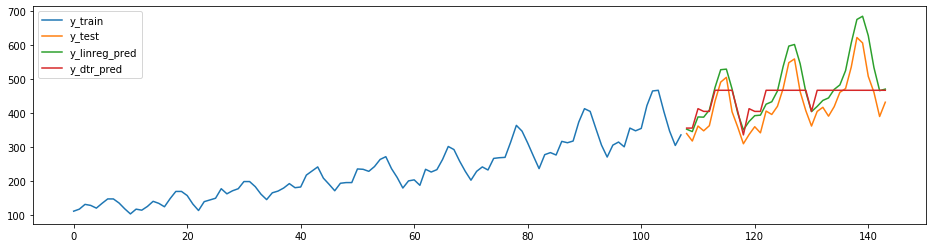

In [47]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

linreg = LinearRegression()
linreg_forecaster = ReducedRegressionForecaster(linreg, window_length=12)
linreg_forecaster.fit(y_train)
y_linreg_pred = linreg_forecaster.predict(fh)

dtr = DecisionTreeRegressor()
dtr_forecaster = ReducedRegressionForecaster(dtr, window_length=12)
dtr_forecaster.fit(y_train)
y_dtr_pred = dtr_forecaster.predict(fh)

plot_ys(y_train, y_test, y_linreg_pred,y_dtr_pred, labels=['y_train', 'y_test','y_linreg_pred', 'y_dtr_pred'])
print('')
print('SMAPE usando Regressão Linear: ', smape_loss(y_linreg_pred, y_test))
print('SMAPE usando Árvore de Decisão: ', smape_loss(y_dtr_pred, y_test))
print('')

Podemos utilizar também métodos de previsão estatísticos como `AutoArima`.

ARIMA significa: "Média Móvel Integrada Regressiva Automática". O ARIMA é um modelo simples de série temporal estocástica que podemos usar para treinar e prever pontos futuros.
O ARIMA pode capturar relacionamentos complexos, pois leva termos de erro e observações de termos atrasados. Esses modelos dependem da regressão de uma variável em valores passados.

P (Auto Regressivo), D (Integrado) e Q (Média Móvel) são as três propriedades do modelo ARIMA.

A função `AutoArima` escolhe o melhor modelo possível de ARIMA calculando as propriedades automaticamente. Novamente, precisamos configurar apenas o parâmetro `sp` (janela desejada). 

obs: Para utilizar esta função precisamos ter instalado a biblioteca pmdarima. Caso você não a tenha, basta executar `pip install pmdarima`.

In [20]:
from sktime.forecasting.arima import AutoARIMA

arima_forecasting = AutoARIMA(sp=12)
arima_forecasting.fit(y_train)

y_arima = arima_forecasting.predict(fh)


SMAPE usando ARIMA:  0.07570877993867646



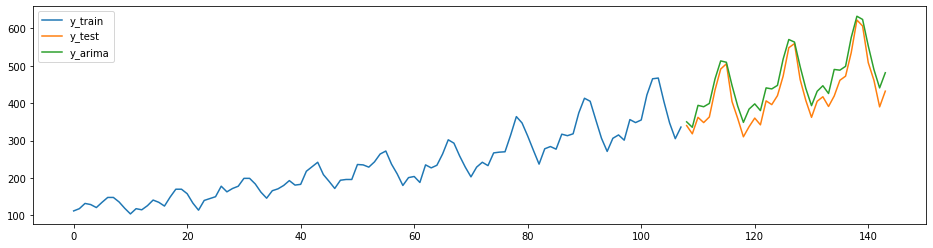

In [22]:
plot_ys(y_train, y_test, y_arima, labels=['y_train', 'y_test', 'y_arima'])
print('')
print('SMAPE usando ARIMA: ', smape_loss(y_arima, y_test))
print('')

Por fim, nossos exemplos obtiveram os seguintes valores de erro para SMAPE:

In [41]:
import pandas as pd

name_list = ['Last', 'Seasonal Last', 'Random Forest Regressor', 'Linear Regression', 'Decision Tree Regressor', 'ARIMA']
error_list = np.round([smape_loss(y_last, y_test),smape_loss(y_seasonal_last, y_test),smape_loss(y_rfr_pred, y_test),smape_loss(y_linreg_pred, y_test),smape_loss(y_dtr_pred, y_test),smape_loss(y_arima, y_test)],3)

df_error = pd.DataFrame({'Modelo':name_list, 'Erro':error_list})
df_error.sort_values('Erro', ascending=True)

,Modelo,Erro
5,ARIMA,0.076
3,Linear Regression,0.103
2,Random Forest Regressor,0.128
1,Seasonal Last,0.145
4,Decision Tree Regressor,0.145
0,Last,0.232


Fontes:
- https://towardsdatascience.com/arima-simplified-b63315f27cbc
- https://github.com/alan-turinginstitute/sktime/blob/master/examples/01_forecasting.ipynb
- https://towardsdatascience.com/sktime-a-unified-python-library-for-time-series-machine-learning-3c103c139a55

Meu Linkedin: https://www.linkedin.com/in/souzapatrick/